In [4]:
import praw
import pandas as pd

reddit = praw.Reddit(
    client_id="o6Z84Z0rxget-8ybCfVSnQ",             # 👈 this is your "client_id"
    client_secret="vkGVNxboxgpuQC2QKqJ--9nRB6mNYw",  # 👈 this is your "client_secret"
    user_agent="llmforge-reddit-crawler by Hindol007"  # 👈 any custom string that identifies your app
)


def fetch_reddit_posts(subreddit="learnmachinelearning", limit=50, max_comments=5):
    posts = []
    for post in reddit.subreddit(subreddit).new(limit=limit):
        if post.selftext:
            post.comments.replace_more(limit=0)  # flatten
            comments = [c.body.strip() for c in post.comments[:max_comments] if len(c.body.strip()) > 10]
            
            posts.append({
                "id": post.id,
                "title": post.title.strip(),
                "text": post.selftext.strip(),
                "url": post.url,
                "comments": comments
            })
    return pd.DataFrame(posts)


df_raw = fetch_reddit_posts()
df_raw.head()

,id,title,text,url,comments
0,1lglp8n,Best open-source model to fine-tune for large ...,"Hi all,\n\nI’m building an AI pipeline which w...",https://www.reddit.com/r/learnmachinelearning/...,[]
1,1lgkpsq,How do you assess a probability reliability cu...,When looking at a probability reliability curv...,https://i.redd.it/msz39lufo68f1.jpeg,[That’s better than any reliability curve I’ve...
2,1lgidql,I just learned AI,"Hi, I'm new to AI. What do I need to learn fro...",https://www.reddit.com/r/learnmachinelearning/...,"[Yes , to learn., There are plenty of learning..."
3,1lgibva,ML Concepts and/or System Design Q&As for Flas...,Is anyone aware of questions and answers on ML...,https://www.reddit.com/r/learnmachinelearning/...,[My [ML engineer book](https://a.co/d/ecxqK7p)...
4,1lgi049,throat singing,could machine learning understand what is bein...,https://www.reddit.com/r/learnmachinelearning/...,"[well I can't, why shouldn't a machine have be..."


In [5]:
from detoxify import Detoxify

def filter_posts(df, min_words=30, max_toxicity=0.5):
    df["word_count"] = df["text"].apply(lambda x: len(x.split()))
    df = df[df["word_count"] >= min_words]
    
    # Toxicity check
    toxicity_scores = Detoxify("original").predict(list(df["text"]))
    df["toxicity"] = toxicity_scores["toxicity"]
    df = df[df["toxicity"] < max_toxicity]
    
    df = df.drop(columns=["word_count", "toxicity"])
    return df.reset_index(drop=True)

df_clean = filter_posts(df_raw)
df_clean.head()


/tmp/ipykernel_14002/3732640450.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["toxicity"] = toxicity_scores["toxicity"]


,id,title,text,url,comments
0,1lglp8n,Best open-source model to fine-tune for large ...,"Hi all,\n\nI’m building an AI pipeline which w...",https://www.reddit.com/r/learnmachinelearning/...,[]
1,1lgkpsq,How do you assess a probability reliability cu...,When looking at a probability reliability curv...,https://i.redd.it/msz39lufo68f1.jpeg,[That’s better than any reliability curve I’ve...
2,1lgibva,ML Concepts and/or System Design Q&As for Flas...,Is anyone aware of questions and answers on ML...,https://www.reddit.com/r/learnmachinelearning/...,[My [ML engineer book](https://a.co/d/ecxqK7p)...
3,1lgh83s,I built a system that scrapes every company ca...,I realized most job openings are quietly poste...,https://www.reddit.com/r/learnmachinelearning/...,[Make sure to keep making new accounts people ...
4,1lggcmp,Highlighting similar words when comparing two ...,"Hello, I am working on a proof of concept.\n\n...",https://www.reddit.com/r/learnmachinelearning/...,[]


In [6]:
df_clean["prompt"] = df_clean["title"] + "\n\n" + df_clean["text"]
df_clean["completion"] = df_clean["comments"].apply(lambda x: "\n".join(x[:3]))
df_clean[["prompt", "completion"]].to_json("reddit_post_plus_comments.jsonl", orient="records", lines=True)


In [7]:
def is_good_completion(comments):
    return any(len(c.split()) > 10 for c in comments[:3])

df_clean[df_clean["comments"].apply(is_good_completion)]


,id,title,text,url,comments,prompt,completion
1,1lgkpsq,How do you assess a probability reliability cu...,When looking at a probability reliability curv...,https://i.redd.it/msz39lufo68f1.jpeg,[That’s better than any reliability curve I’ve...,How do you assess a probability reliability cu...,That’s better than any reliability curve I’ve ...
2,1lgibva,ML Concepts and/or System Design Q&As for Flas...,Is anyone aware of questions and answers on ML...,https://www.reddit.com/r/learnmachinelearning/...,[My [ML engineer book](https://a.co/d/ecxqK7p)...,ML Concepts and/or System Design Q&As for Flas...,My [ML engineer book](https://a.co/d/ecxqK7p) ...
3,1lgh83s,I built a system that scrapes every company ca...,I realized most job openings are quietly poste...,https://www.reddit.com/r/learnmachinelearning/...,[Make sure to keep making new accounts people ...,I built a system that scrapes every company ca...,Make sure to keep making new accounts people w...
6,1lgc9qa,Need help with this machine learning book,I have recently started learning machine learn...,https://www.reddit.com/r/learnmachinelearning/...,"[2nd is fine, just expect some of the packages...",Need help with this machine learning book\n\nI...,"2nd is fine, just expect some of the packages ..."
9,1lg9etp,Exploring a ChatGPT Alternative for PDF Conten...,Tested some different AI tools for working wit...,https://www.reddit.com/r/learnmachinelearning/...,[I faced similar challenges working with massi...,Exploring a ChatGPT Alternative for PDF Conten...,I faced similar challenges working with massiv...
11,1lg8jqy,Where do I go from here?,Managed to land a Python automation paid inter...,https://www.reddit.com/r/learnmachinelearning/...,"[First up, congratulations. You're already in ...",Where do I go from here?\n\nManaged to land a ...,"First up, congratulations. You're already in a..."
13,1lg7u5c,Best practices for integrating a single boolea...,I'm working on a binary classification task us...,https://www.reddit.com/r/learnmachinelearning/...,[Here's a quick hack you could try: encode the...,Best practices for integrating a single boolea...,Here's a quick hack you could try: encode the ...
15,1lg7nph,Classification problems with p>>n,I've been recently working on some microarray ...,https://www.reddit.com/r/learnmachinelearning/...,[maybe try cross validations? if you have 50 ...,Classification problems with p>>n\n\nI've been...,maybe try cross validations? if you have 50 s...
16,1lg6gk2,Interested in SciML– How to Get Started & What...,"Hey everyone, I'm a 2nd year CSE undergrad who...",https://www.reddit.com/r/learnmachinelearning/...,"[Question to you,\n\nWhat are you interested i...",Interested in SciML– How to Get Started & What...,"Question to you,\n\nWhat are you interested in..."
23,1lfyylt,Should I retrain my model on the entire datase...,"Hello everyone,\n\nI have a question regarding...",https://www.reddit.com/r/learnmachinelearning/...,[I think that you have to split data into trai...,Should I retrain my model on the entire datase...,I think that you have to split data into train...


In [8]:
import re

def clean_text(text):
    # Remove markdown links [text](url)
    text = re.sub(r"\[.*?\]\(.*?\)", "", text)

    # Remove raw URLs
    text = re.sub(r"http\S+", "", text)

    # Remove emojis and non-ascii
    text = text.encode("ascii", "ignore").decode()

    # Normalize spacing
    text = re.sub(r"\n+", "\n", text)  # collapse multiple newlines
    text = re.sub(r"\s+", " ", text)   # collapse whitespace
    text = text.strip()

    return text
df_clean["clean_title"] = df_clean["title"].apply(clean_text)
df_clean["clean_text"] = df_clean["text"].apply(clean_text)
df_clean["prompt"] = df_clean["clean_title"] + "\n\n" + df_clean["clean_text"]
df_clean["completion"] = df_clean["comments"].apply(lambda x: "\n".join(x[:3]))
df_clean[["prompt", "completion"]].to_json(
    "data_cleaned.jsonl", orient="records", lines=True
)


In [6]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import umap
from sklearn.cluster import DBSCAN
import json

#loading the cleaned data
with open("data_cleaned.jsonl", "r") as f:
    data = [json.loads(line) for line in f]
df = pd.DataFrame(data)

#use prompt column for embeddings
texts = df["prompt"].tolist()

#generate embeddings
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(texts, show_progress_bar=True)

#reduce dimensionality with UMAP for clustering
reducer = umap.UMAP(n_neighbors=15, n_components=3, metric='cosine', random_state=42)
embeddings_umap = reducer.fit_transform(embeddings)

#cluster using DBSCAN
clustering = DBSCAN(eps=0.7, min_samples=3).fit(embeddings_umap)
df['cluster'] = clustering.labels_
df['x'] = embeddings_umap[:, 0]
df['y'] = embeddings_umap[:, 1]

df.to_json('data_with_clusters.jsonl', orient='records', lines=True)

df['cluster'].value_counts()


Batches: 100%|██████████| 2/2 [00:00<00:00,  8.14it/s]
/home/kenzi/turboML-project/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kenzi/turboML-project/venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


cluster
 1    14
 0    13
 3     8
 2     5
-1     2
Name: count, dtype: int64

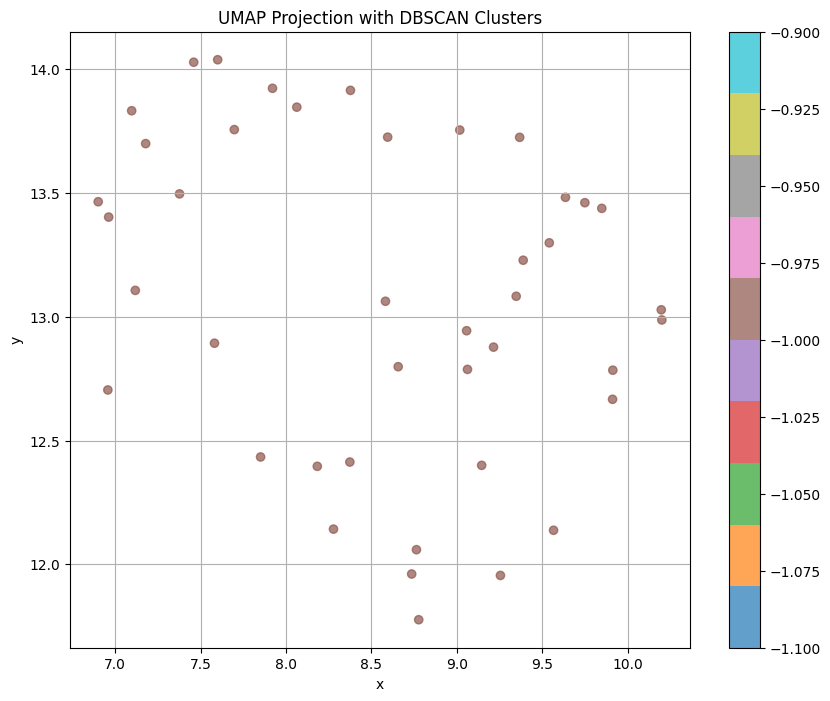

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
scatter = plt.scatter(df["x"], df["y"], c=df["cluster"], cmap="tab10", alpha=0.7)
plt.title("UMAP Projection with DBSCAN Clusters")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar(scatter)
plt.grid(True)
plt.show()
